In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import os
import tensorflow as tf
from tensorflow import keras
import torch

np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 8)

2025-09-08 00:20:36.967283: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-08 00:20:36.975508: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-08 00:20:37.252501: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-08 00:20:38.498258: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
data_path = '../data/raw/indianpinearray.npy'
gt_path = '../data/raw/IPgt.npy'

X = np.load(data_path)
y = np.load(gt_path)

print(f"Data Shape: {X.shape}")
print(f"Ground Truth Shape: {y.shape}")
print(f"Data type: {X.dtype}")
print(f"Data range: [{X.min()}, {X.max()}]")

unique_classes, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} pixels")

Data Shape: (145, 145, 200)
Ground Truth Shape: (145, 145)
Data type: uint16
Data range: [955, 9604]

Class distribution:
Class 0: 10776 pixels
Class 1: 46 pixels
Class 2: 1428 pixels
Class 3: 830 pixels
Class 4: 237 pixels
Class 5: 483 pixels
Class 6: 730 pixels
Class 7: 28 pixels
Class 8: 478 pixels
Class 9: 20 pixels
Class 10: 972 pixels
Class 11: 2455 pixels
Class 12: 593 pixels
Class 13: 205 pixels
Class 14: 1265 pixels
Class 15: 386 pixels
Class 16: 93 pixels


In [3]:
labeled_pixels = y != 0
print(f"Number of labeled pixels: {np.sum(labeled_pixels)}")

Number of labeled pixels: 10249


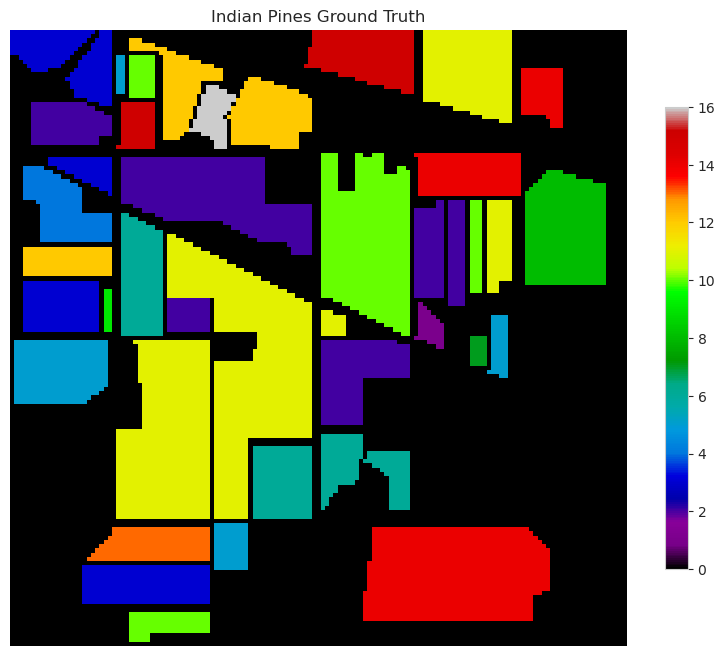

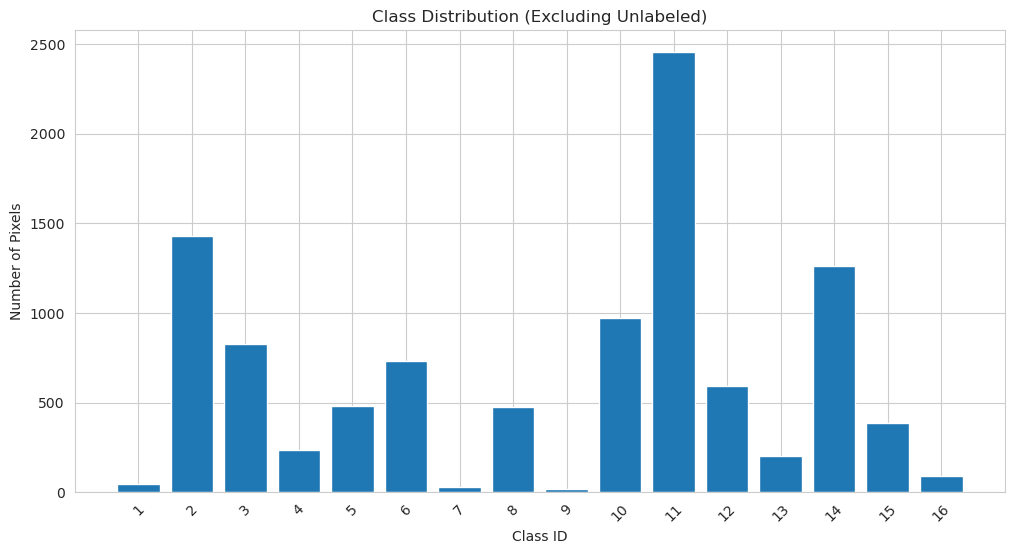

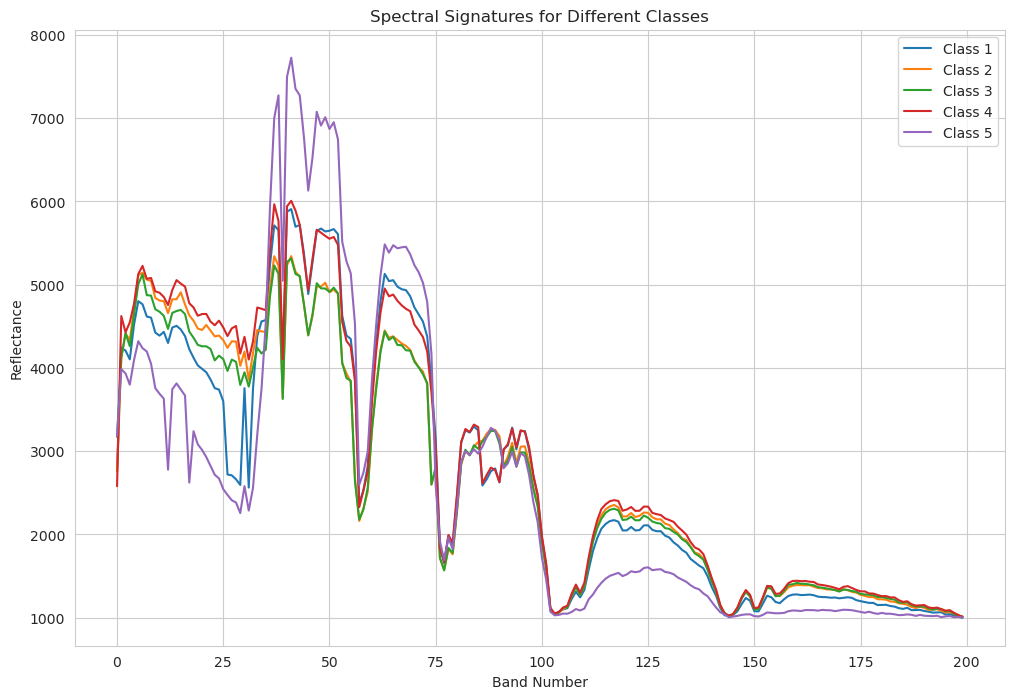

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar(shrink=0.75)
plt.title('Indian Pines Ground Truth')
plt.axis('off')
plt.show()

class_ids = unique_classes[1:]
class_counts = counts[1:]

plt.figure(figsize=(12, 6))
plt.bar(class_ids.astype(str), class_counts)
plt.title('Class Distribution (Excluding Unlabeled)')
plt.xlabel('Class ID')
plt.ylabel('Number of Pixels')
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(12, 8))
for class_id in class_ids[:5]: 
    rows, cols = np.where(y == class_id)
    if len(rows) > 0:
        idx = np.random.randint(0, len(rows))
        spectrum = X[rows[idx], cols[idx], :]
        plt.plot(spectrum, label=f'Class {class_id}')
        
plt.title('Spectral Signatures for Different Classes')
plt.xlabel('Band Number')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

In [5]:
original_shape = X.shape
X_flat = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
X_scaled_flat = scaler.fit_transform(X_flat)
X_scaled = X_scaled_flat.reshape(original_shape)
print(f"New data range: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")

New data range: [-7.64, 8.99]


In [6]:
rows, cols = np.where(y != 0)
labels = y[rows, cols]
pixel_samples = list(zip(rows, cols, labels))
train_val_pixels, test_pixels, train_val_labels, test_labels = train_test_split(
    pixel_samples, labels, test_size=0.2, random_state=42, stratify=labels
)
train_pixels, val_pixels, train_labels, val_labels = train_test_split(
    train_val_pixels, train_val_labels, test_size=0.25, random_state=42, stratify=train_val_labels
)

print(f"Training pixels: {len(train_pixels)}")
print(f"Validation pixels: {len(val_pixels)}")
print(f"Test pixels: {len(test_pixels)}")

def check_class_distribution(samples, name):
    labels = [s[2] for s in samples]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{name} class distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} pixels ({count/len(labels)*100:.1f}%)")
        
check_class_distribution(train_pixels, "Training")
check_class_distribution(val_pixels, "Validation")
check_class_distribution(test_pixels, "Test")

Training pixels: 6149
Validation pixels: 2050
Test pixels: 2050

Training class distribution:
Class 1: 28 pixels (0.5%)
Class 2: 856 pixels (13.9%)
Class 3: 498 pixels (8.1%)
Class 4: 143 pixels (2.3%)
Class 5: 289 pixels (4.7%)
Class 6: 438 pixels (7.1%)
Class 7: 17 pixels (0.3%)
Class 8: 287 pixels (4.7%)
Class 9: 12 pixels (0.2%)
Class 10: 583 pixels (9.5%)
Class 11: 1473 pixels (24.0%)
Class 12: 355 pixels (5.8%)
Class 13: 123 pixels (2.0%)
Class 14: 759 pixels (12.3%)
Class 15: 232 pixels (3.8%)
Class 16: 56 pixels (0.9%)

Validation class distribution:
Class 1: 9 pixels (0.4%)
Class 2: 286 pixels (14.0%)
Class 3: 166 pixels (8.1%)
Class 4: 47 pixels (2.3%)
Class 5: 97 pixels (4.7%)
Class 6: 146 pixels (7.1%)
Class 7: 6 pixels (0.3%)
Class 8: 95 pixels (4.6%)
Class 9: 4 pixels (0.2%)
Class 10: 195 pixels (9.5%)
Class 11: 491 pixels (24.0%)
Class 12: 119 pixels (5.8%)
Class 13: 41 pixels (2.0%)
Class 14: 253 pixels (12.3%)
Class 15: 77 pixels (3.8%)
Class 16: 18 pixels (0.9%)

Test

In [7]:
np.save('../data/processed/train_train_pixels.npy', train_pixels)
np.save('../data/processed/val_pixels.npy', val_pixels)
np.save('../data/processed/test_pixels.npy', test_pixels)

In [8]:
def extract_patches(X, y, pixels_list, patch_size=25):
    half = patch_size // 2
    patches = []
    labels = []
    X_padded = np.pad(X, ((half, half), (half, half), (0, 0)), mode='reflect')
    y_padded = np.pad(y, ((half, half), (half, half)), mode='reflect')
    
    for row, col, label in pixels_list:
        row_adj = row + half
        col_adj = col + half
        patch = X_padded[row_adj-half:row_adj+half+1, col_adj-half:col_adj+half+1, :]
        patches.append(patch)
        labels.append(label)
    
    return np.array(patches), np.array(labels)
test_sample = train_pixels[:5]
test_patches, test_labels = extract_patches(X_scaled, y, test_sample, patch_size=25)

print(f"Extracted {len(test_patches)} patches of shape {test_patches.shape}")

Extracted 5 patches of shape (5, 25, 25, 200)


In [9]:
X_train, y_train = extract_patches(X_scaled, y, train_pixels, patch_size=25)

X_val, y_val = extract_patches(X_scaled, y, val_pixels, patch_size=25)

X_test, y_test = extract_patches(X_scaled, y, test_pixels, patch_size=25)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (6149, 25, 25, 200), (6149,)
Validation set: (2050, 25, 25, 200), (2050,)
Test set: (2050, 25, 25, 200), (2050,)


In [10]:
n_train, h, w, b = X_train.shape
X_train_flat = X_train.reshape(-1, b)
pca = PCA(n_components=30)  
X_train_pca_flat = pca.fit_transform(X_train_flat)

X_train_pca = X_train_pca_flat.reshape(n_train, h, w, -1)

print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.3f}")

X_val_flat = X_val.reshape(-1, b)
X_val_pca_flat = pca.transform(X_val_flat)
X_val_pca = X_val_pca_flat.reshape(X_val.shape[0], h, w, -1)

X_test_flat = X_test.reshape(-1, b)
X_test_pca_flat = pca.transform(X_test_flat)
X_test_pca = X_test_pca_flat.reshape(X_test.shape[0], h, w, -1)

print(f"Training set: {X_train_pca.shape}")
print(f"Validation set: {X_val_pca.shape}")
print(f"Test set: {X_test_pca.shape}")

Explained variance ratio: 0.985
Training set: (6149, 25, 25, 30)
Validation set: (2050, 25, 25, 30)
Test set: (2050, 25, 25, 30)


In [11]:
np.save('../data/processed/X_train_pca.npy', X_train_pca)
np.save('../data/processed/X_val_pca.npy', X_val_pca)
np.save('../data/processed/X_test_pca.npy', X_test_pca)
np.save('../data/processed/y_train.npy', y_train)
np.save('../data/processed/y_val.npy', y_val)
np.save('../data/processed/y_test.npy', y_test)

import joblib
joblib.dump(pca, '../data/processed/pca_model.pkl')
joblib.dump(scaler, '../data/processed/scaler.pkl')

['../data/processed/scaler.pkl']

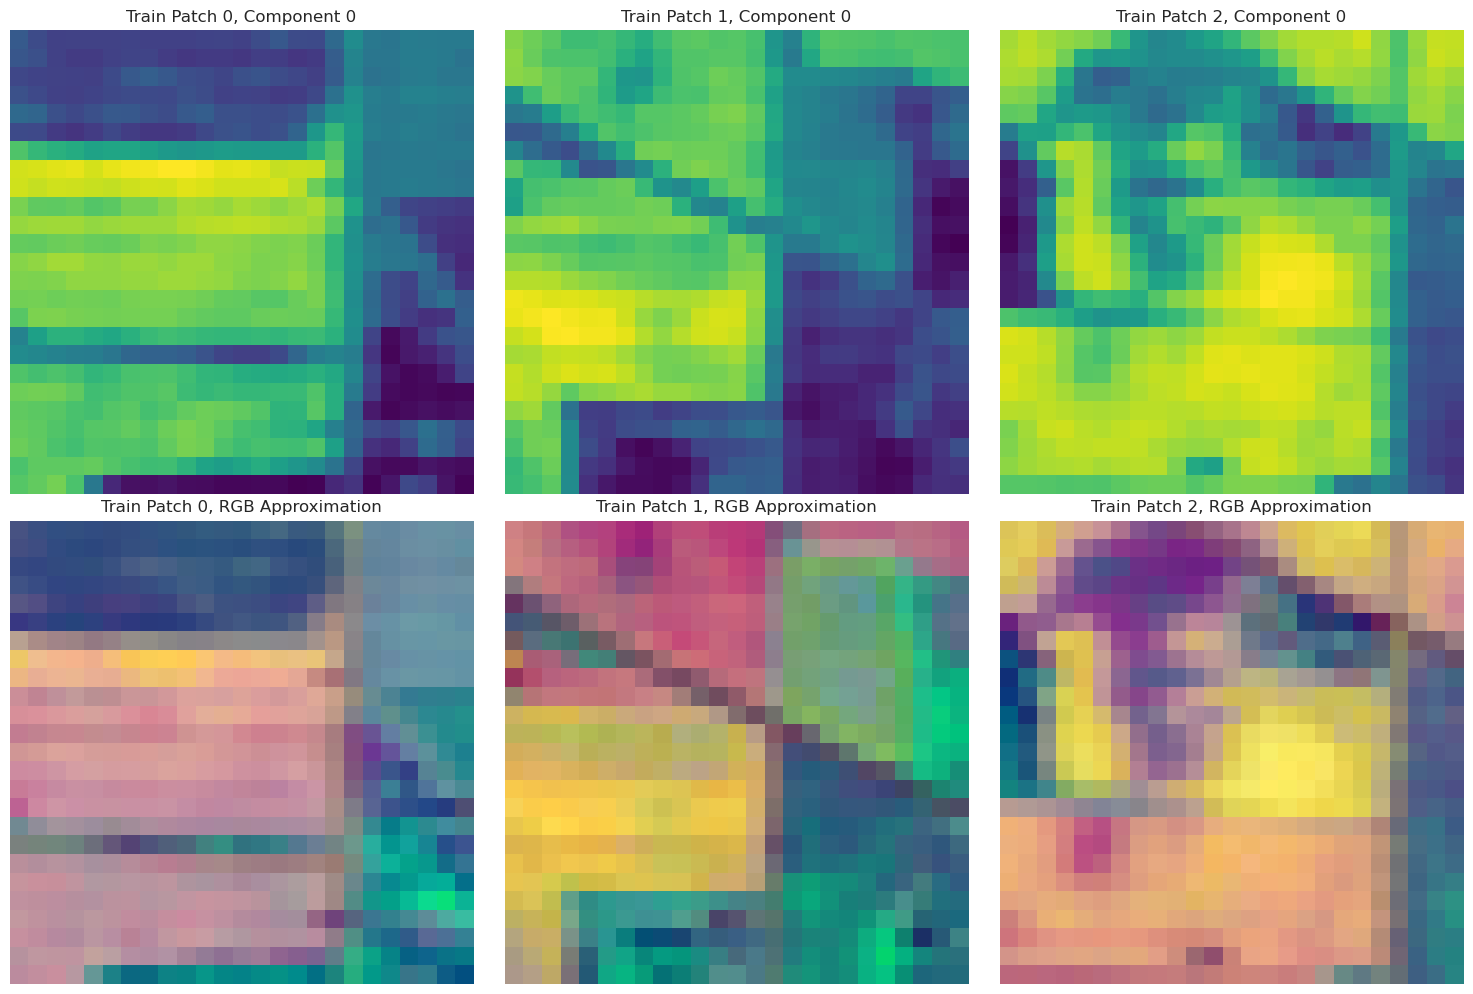

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(3):
    axes[0, i].imshow(X_train_pca[i, :, :, 0], cmap='viridis')
    axes[0, i].set_title(f'Train Patch {i}, Component 0')
    axes[0, i].axis('off')
    rgb_patch = X_train_pca[i, :, :, :3]
    rgb_patch = (rgb_patch - rgb_patch.min()) / (rgb_patch.max() - rgb_patch.min())
    axes[1, i].imshow(rgb_patch)
    axes[1, i].set_title(f'Train Patch {i}, RGB Approximation')
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()